# Optimising for adaptation as a circuit function through automatic gradient calculation

In order to find the derivative of adaptation, we need to be able to differentiate the dynamic simulation and the analytics calculated from it that are used to calculate adaptability. We need to be able to find the derivative of the sensitivity and precision with respect to the circuit topology. 

1. Set up a simple test circuit simulation environment
2. Re-write the dynamic simulation to keep track of the max / min of all species
3. Try to differentiate that

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports 

In [11]:
from jax import jacrev
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


np.random.seed(0)
jax.devices()

[cuda(id=0)]

In [12]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_sensitivity, compute_precision, compute_peaks

# Test environment for example circuits

In [13]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_1']
idxs_signal = [species.index(s) for s in species_signal]
idxs_output = [species.index(s) for s in species_output]
idxs_unbound = [species.index(s) for s in species_unbound]
idxs_bound = [species.index(s) for s in species_bound]
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Initial parameters
n_circuits = 1000
n_circuits_display = 30
k_a = 0.00150958097
N0 = 200
y00 = np.array([[N0, N0, N0, 0, 0, 0, 0, 0, 0]]).astype(np.float32)
y00 = np.repeat(y00, repeats=n_circuits, axis=0)

# Simulation parameters
signal_target = 2
t0 = 0
t1 = 200
ts = np.linspace(t0, t1, 500)
dt0 = 0.0005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10

# Reactions
# rates = np.array([[1e-4, 1e-4, 1e1],
#                   [1e-4, 1e-6, 1e-4],
#                   [1e1, 1e-4, 1e-4]])
# eqconstants = np.random.rand(n_circuits, len(species_unbound), len(species_unbound))
# eqconstants = np.exp(np.interp(eqconstants, (eqconstants.min(), eqconstants.max()), (-6, 2)))
energies = np.random.rand(n_circuits, len(species_unbound), len(species_unbound))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
energies[np.tril_indices(len(species_unbound))] = energies[np.triu_indices(len(species_unbound))]
eqconstants = jax.vmap(equilibrium_constant_reparameterisation)(energies, y00[:, np.array(idxs_unbound)])
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float32)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float32)

# Rates
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], eqconstants)))
# forward_rates = np.ones_like(reverse_rates) * k_a

In [14]:
# def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
#     concentration_factors_in = jnp.prod(
#         jnp.power(spec_conc, (inputs)), axis=1)
#     concentration_factors_out = jnp.prod(
#         jnp.power(spec_conc, (outputs)), axis=1)
#     forward_delta = concentration_factors_in * forward_rates
#     reverse_delta = concentration_factors_out * reverse_rates
#     return (forward_delta - reverse_delta) @ (outputs - inputs)


# # bb = partial(bioreaction_sim_dfx_expanded,
# #              t0=t0, t1=t1, dt0=dt0,
# #              signal=None, signal_onehot=signal_onehot,
# #              forward_rates=forward_rates,
# #              inputs=inputs,
# #              outputs=outputs,
# #              solver=dfx.Tsit5(),
# #              saveat=dfx.SaveAt(
# #                  ts=ts),
# #              max_steps=max_steps,
# #              stepsize_controller=make_piecewise_stepcontrol(
# #                  t0=t0, t1=t1, dt0=dt0, dt1=dt1)
# #              )

# Jbb = jax.vmap(jacrev(partial(one_step_de_sim_expanded,
#                      forward_rates=forward_rates[0],
#                      inputs=inputs,
#                      outputs=outputs)))


# sol_jac = Jbb(y00, reverse_rates=reverse_rates)

# nr = 2
# nc = int(np.ceil(n_circuits_display / nr))
# fig = plt.figure(figsize=(4*nc, 4*nr))
# for idx_circuit in range(n_circuits_display):
#     ax = fig.add_subplot(nr, nc, idx_circuit+1)
#     ax.set_title(f'Circuit {idx_circuit}')
#     plt.imshow(sol_jac[idx_circuit])
#     plt.clim([sol_jac.min(), sol_jac.max()])
# plt.suptitle('Jacobian of system')

# Dynamic simulation

In [15]:
def one_step_de_sim_expanded(t, spec_conc, args, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def wrap(y0,
         reverse_rates,
         solver=dfx.Tsit5(),
         saveat=dfx.SaveAt(
        ts=ts),
        max_steps=max_steps,
        stepsize_controller=make_piecewise_stepcontrol(
        t0=t0, t1=t1, dt0=dt0, dt1=dt1)):
    term = dfx.ODETerm(
        # jax.jacfwd(
        partial(one_step_de_sim_expanded,
                forward_rates=forward_rates[0],
                inputs=inputs,
                outputs=outputs,
                reverse_rates=reverse_rates)
        # )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=None,
                           y0=y0.squeeze(),
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=stepsize_controller)


sol_steady_states = jax.vmap(wrap)(y00, reverse_rates)

y01 = np.array(sol_steady_states.ys[:, -1])
y01[:, np.array(idxs_signal)] = y00[:, np.array(idxs_signal)] * signal_target
sol_signal = jax.vmap(wrap)(y01, reverse_rates)

In [16]:
sol_full_ts = jnp.concatenate([sol_steady_states.ts, sol_signal.ts + sol_steady_states.ts.max()], axis=1)
sol_full_ys = jnp.concatenate([sol_steady_states.ys, sol_signal.ys], axis=1)

Text(0.5, 0.98, 'Dynamic of system')

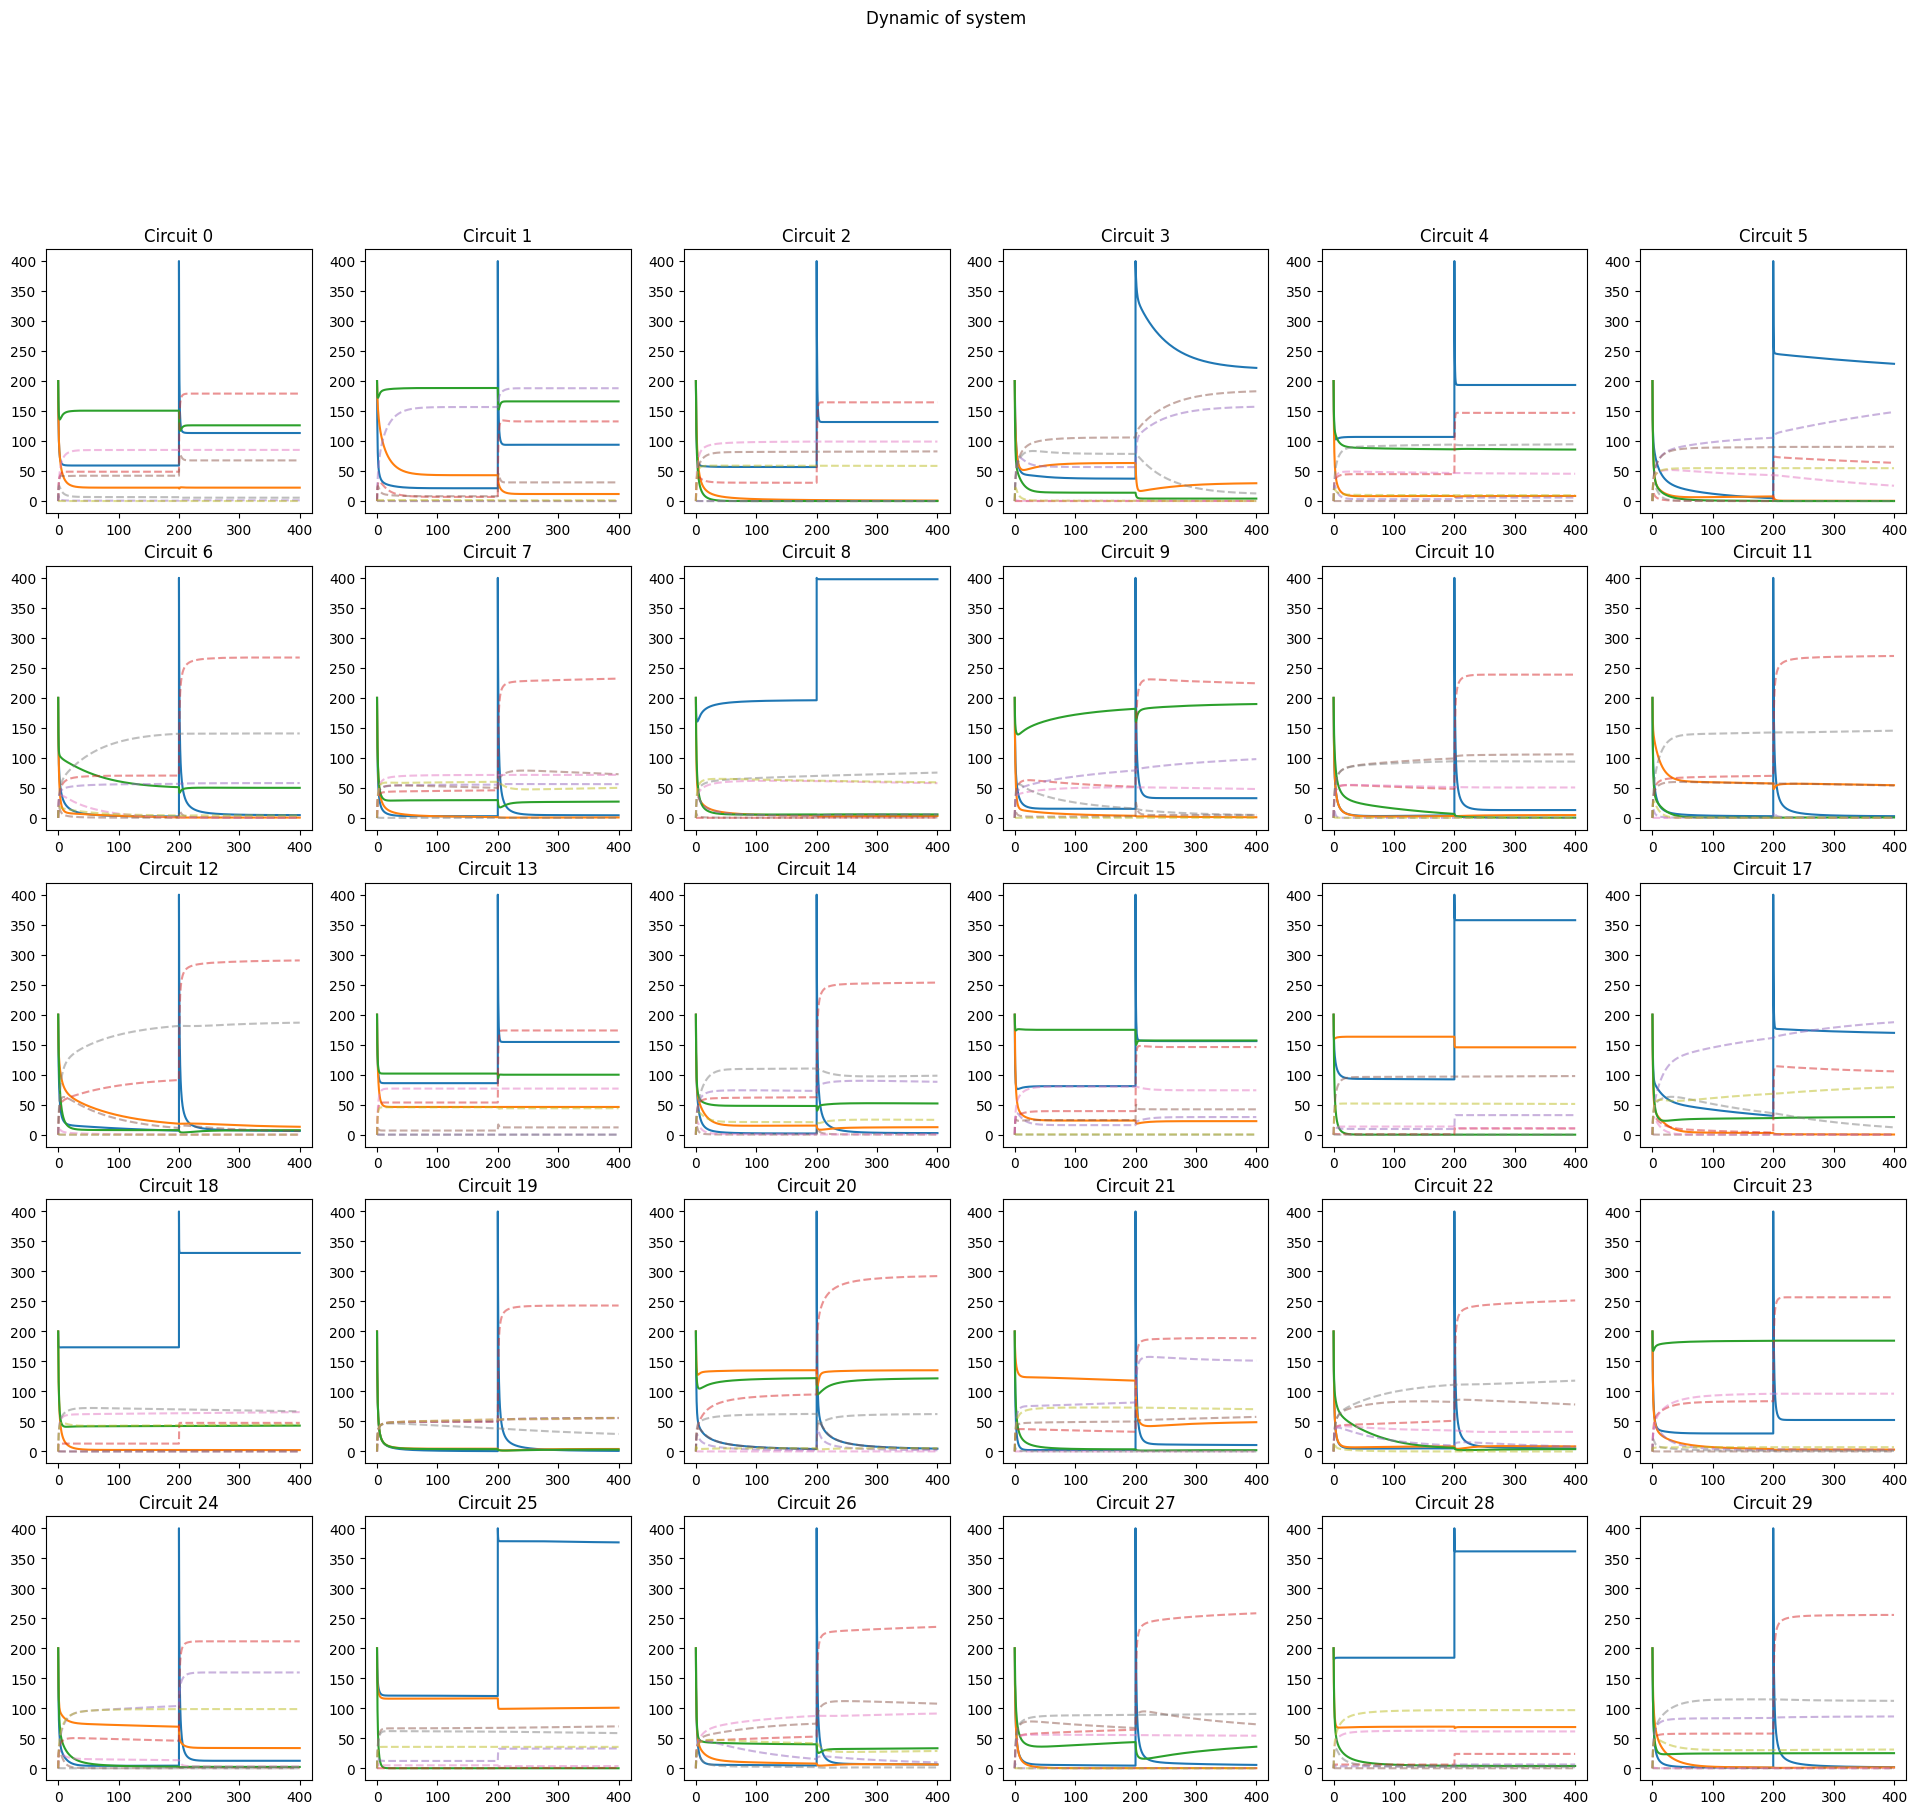

In [17]:
nc = int(np.ceil(np.sqrt(n_circuits_display)))
nr = int(np.ceil(np.sqrt(n_circuits_display)))
fig = plt.figure(figsize=(4*nc, 4*nr))
for idx_circuit in range(n_circuits_display):
    ax = plt.subplot(nr, nc, idx_circuit+1)
    ax.set_title(f'Circuit {idx_circuit}')
    # plt.plot(sol_signal.ts[idx_circuit], sol_signal.ys[idx_circuit], label=species)
    # plt.plot(sol_full_ts[idx_circuit], sol_full_ys[idx_circuit], label=species)
    plt.plot(sol_full_ts[idx_circuit], sol_full_ys[idx_circuit][:, np.array(idxs_unbound)], label=species_unbound)
    plt.plot(sol_full_ts[idx_circuit], sol_full_ys[idx_circuit][:, np.array(idxs_bound)], label=species_bound, alpha=0.5, linestyle='--')
plt.suptitle('Dynamic of system')

## Adaptation

In [18]:
def compute_adaptability_full(ys_steady, ys_signal, idx_sig):
    """ ts: time series with dimensions [t, species] """

    peaks = compute_peaks(ys_steady[-1], ys_signal[-1],
                          ys_signal.max(axis=0), ys_signal.min(axis=0))

    s = compute_sensitivity(
        signal_idx=idx_sig,
        starting_states=ys_steady[-1],
        peaks=peaks
    )
    p = compute_precision(
        starting_states=ys_steady[-1],
        steady_states=ys_signal[-1],
        signal_0=ys_steady[-1, idx_sig],
        signal_1=peaks[idx_sig])
    a = calculate_adaptation(s, p)
    # a = jnp.log(a)
    
    return a, s, p


adaptability, sensitivity, precision = jax.vmap(partial(compute_adaptability_full, idx_sig=idxs_signal[0]))(
    sol_steady_states.ys, sol_signal.ys)

sensitivity = np.array(sensitivity)
precision = np.array(precision)

XlaRuntimeError: INTERNAL: ptxas exited with non-zero error code 139, output: : If the error message indicates that a file could not be written, please verify that sufficient filesystem space is provided.

In [10]:
data = pd.DataFrame()
for a, a_name in zip([adaptability, sensitivity, precision], ['adaptability', 'sensitivity', 'precision']):
    data[a_name] = a.flatten()
data['species'] = species * n_circuits
data['idx_circuit'] = np.repeat(np.arange(n_circuits), len(species))

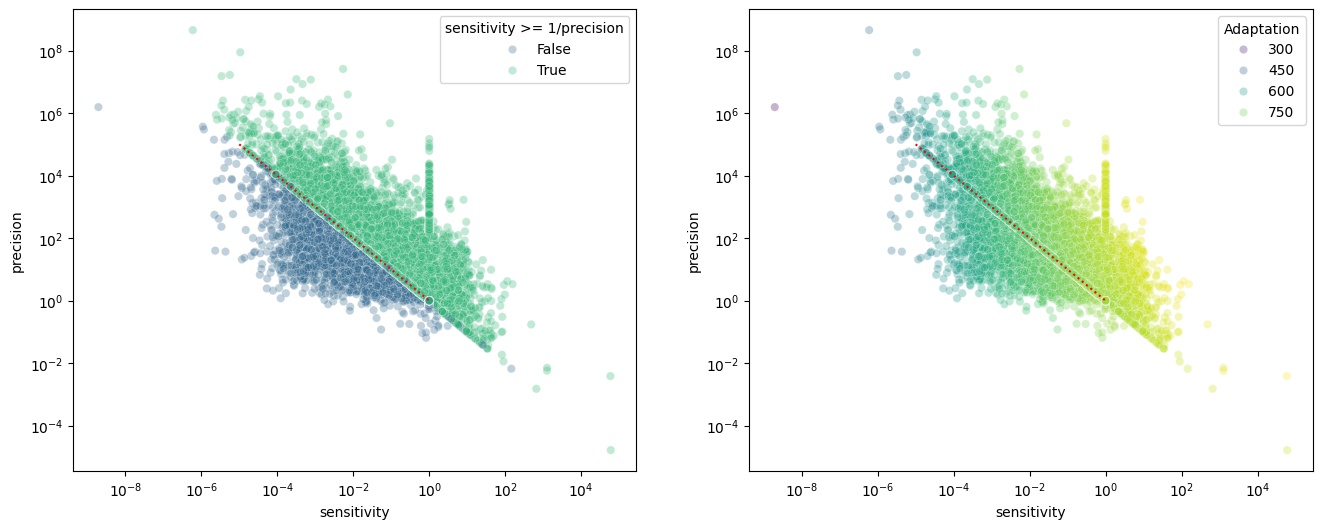

In [11]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(1,2,1)
sns.scatterplot(data[data['species'].isin(species_unbound)], x='sensitivity', y='precision', hue=data['sensitivity'] >= 1/data['precision'], palette='viridis', alpha=0.3)
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
plt.legend(title='sensitivity >= 1/precision')
plt.xscale('log')
plt.yscale('log')

ax = plt.subplot(1,2,2)
sns.scatterplot(data[data['species'].isin(species_unbound)], x='sensitivity', y='precision', hue='adaptability', palette='viridis', alpha=0.3)
plt.plot(np.logspace(-5, 0, 100), np.logspace(5, 0, 100), 'r:')
plt.legend(title='Adaptation')
plt.xscale('log')
plt.yscale('log')

unknown |O_2 - O_1| > |O_p - O_1| = False
Peak outside of bounds |O_2 - O_1| > |O_p - O_1| = True
Peak outside of bounds |O_2 - O_1| > |O_p - O_1| = True
Peak outside of bounds |O_2 - O_1| > |O_p - O_1| = True


Text(0.5, 0.98, 'Weird circuits (sensitivity < 1/precision)')

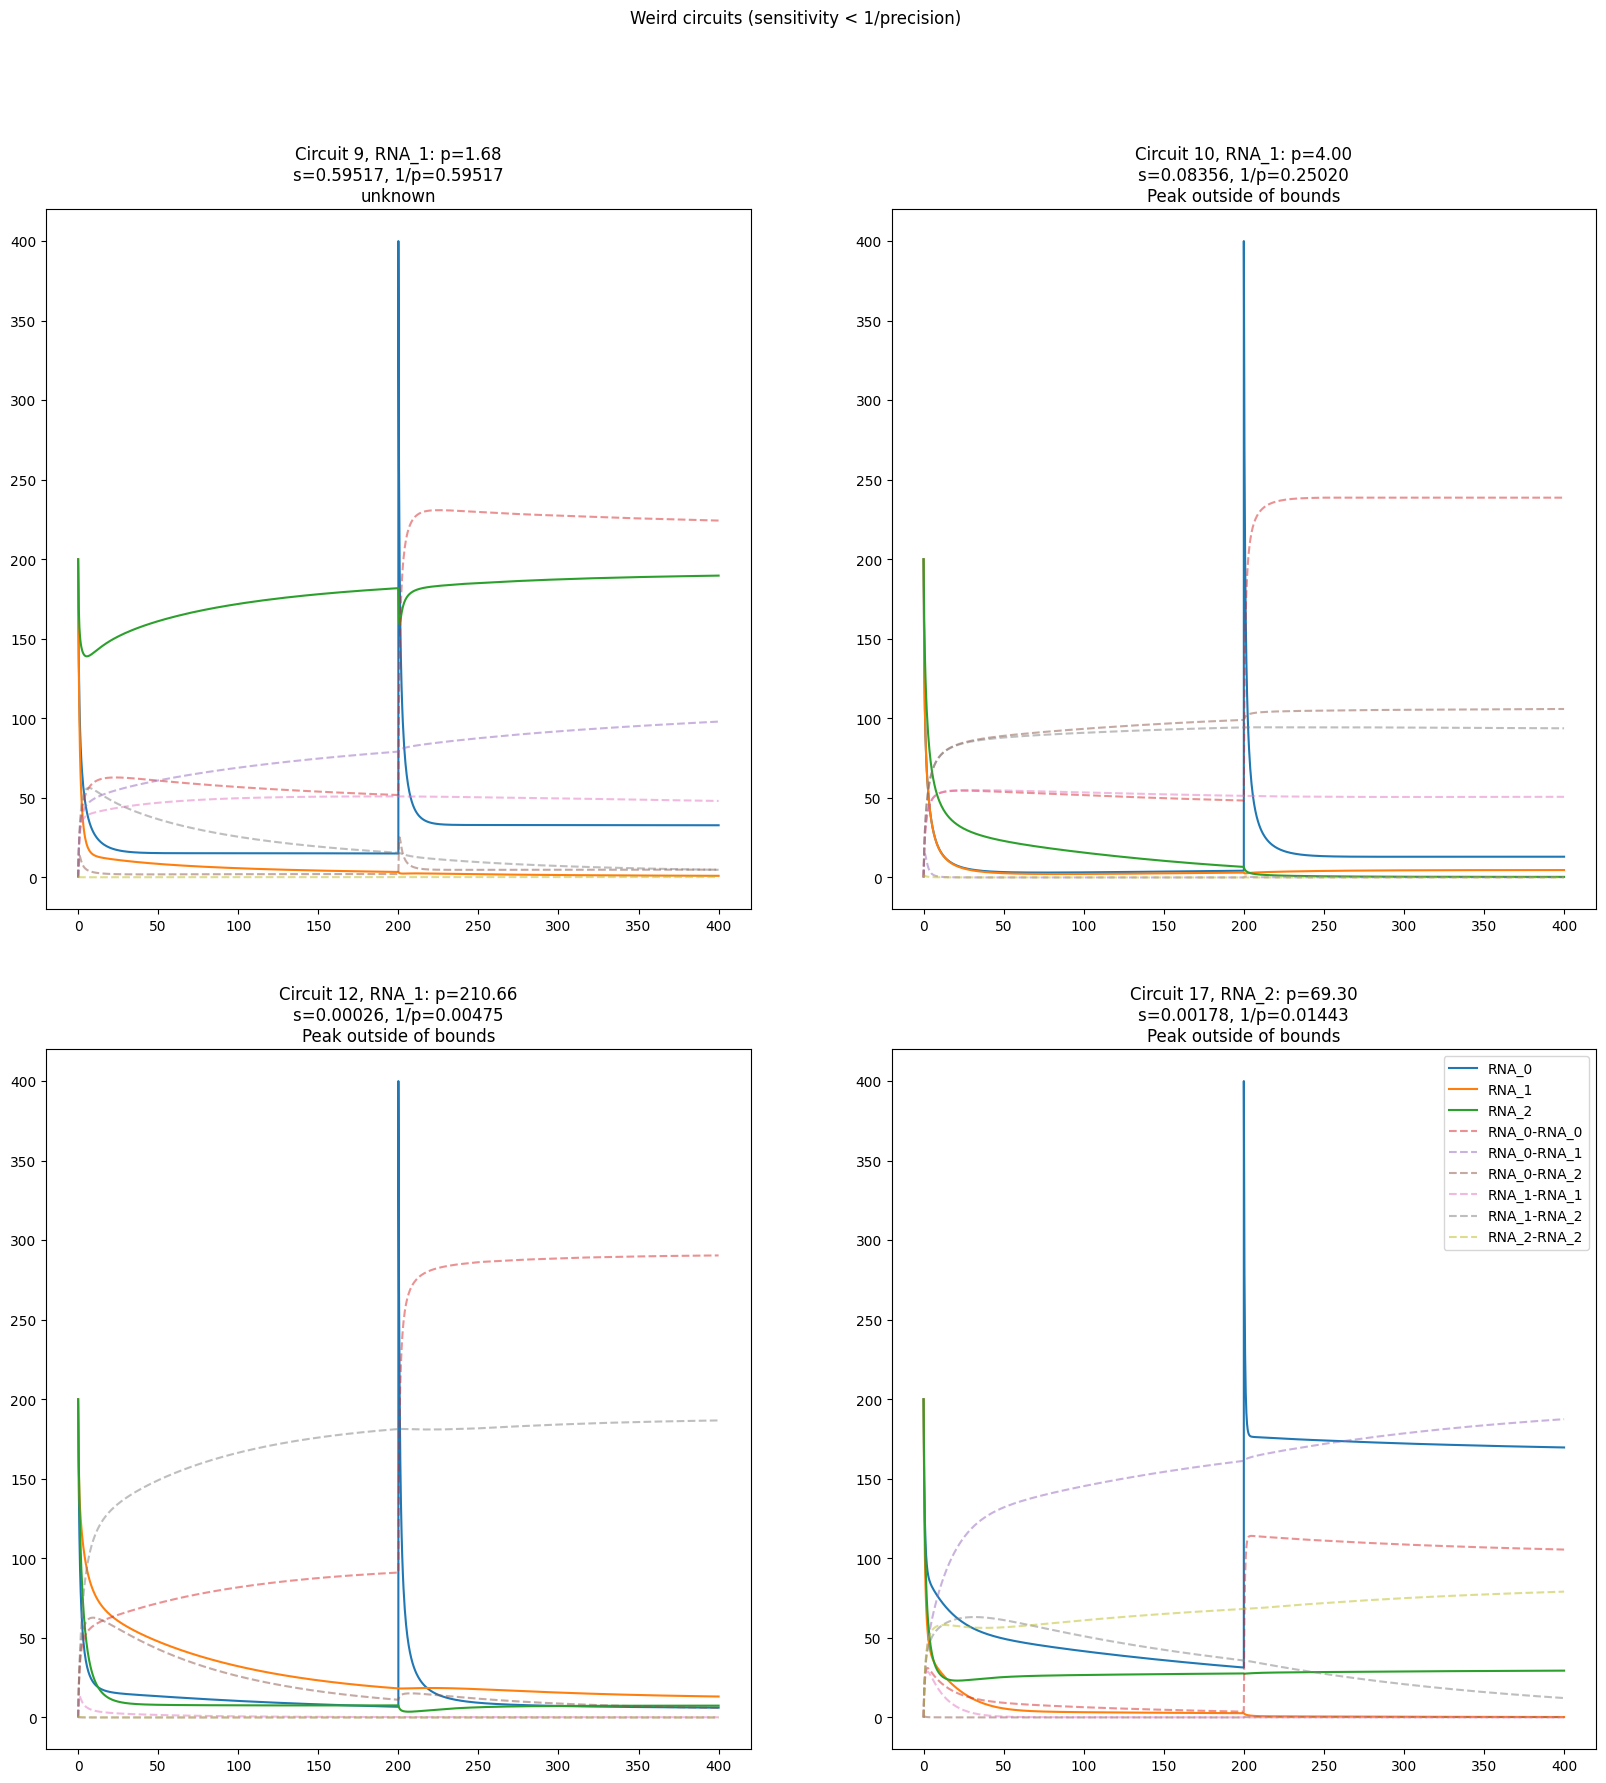

In [12]:
def determine_weird_type(O_2, O_1, O_peak):
    weird_type = 'unknown'
    if ((O_peak < O_2) and (O_peak > O_1)) or ((O_peak > O_2) and (O_peak < O_1)):
        weird_type = 'Peak within bounds'
    elif ((O_peak < O_1) and (O_2 > O_1)) or ((O_peak > O_1) and (O_2 < O_1)):
        weird_type = 'Peak outside of bounds'
    print(weird_type, '|O_2 - O_1| > |O_p - O_1| =', np.abs(O_2 - O_1) > np.abs(O_peak - O_1))
    return weird_type

data_filt = data[data['species'].isin(species_unbound[1:])].sort_values('idx_circuit')
weird_circuits = data_filt[data_filt['sensitivity'] < (1/data_filt['precision'])]

n_circuits_display2 = 4
i_disp = 2
nc = int(np.ceil(np.sqrt(n_circuits_display2)))
nr = int(np.ceil(np.sqrt(n_circuits_display2)))
fig = plt.figure(figsize=(10*nc, 10*nr))
peaks = jax.vmap(compute_peaks)(sol_steady_states.ys[:, -1], sol_signal.ys[:, -1], sol_signal.ys.max(axis=1), sol_signal.ys.min(axis=1))
for i, (_, row) in enumerate(weird_circuits.iloc[i_disp:i_disp + n_circuits_display2].iterrows()):
    idx_circ = row["idx_circuit"]
    specie = row["species"]
    weird_type = determine_weird_type(
        O_2=sol_signal.ys[idx_circ, -1, species.index(specie)],
        O_1=sol_steady_states.ys[idx_circ, -1, species.index(specie)],
        O_peak=peaks[idx_circ, species.index(specie)]
    )
    ax = fig.add_subplot(nr, nc, i+1)
    ax.set_title(f'Circuit {idx_circ}, {specie}: p={precision[idx_circ, species.index(specie)]:.2f}\ns={sensitivity[idx_circ, species.index(specie)]:.5f}, 1/p={1/precision[idx_circ, species.index(specie)]:.5f}\n{weird_type}')
    plt.plot(sol_full_ts[idx_circ], sol_full_ys[idx_circ][:, np.array(idxs_unbound)], label=species_unbound)
    plt.plot(sol_full_ts[idx_circ], sol_full_ys[idx_circ][:, np.array(idxs_bound)], label=species_bound, alpha=0.5, linestyle='--')
    
plt.legend(species)
plt.suptitle('Weird circuits (sensitivity < 1/precision)')

In [1]:
plt.plot(sol_full_ts[idx_circ][:, species.index(specie)], sol_full_ys[idx_circ][:, species.index(specie)], label=species_unbound)
plt.title(f'Circuit {idx_circ}, {specie}: p={precision[idx_circ, species.index(specie)]:.2f}\ns={sensitivity[idx_circ, species.index(specie)]:.5f}, 1/p={1/precision[idx_circ, species.index(specie)]:.5f}\n{weird_type}')

NameError: name 'plt' is not defined

## Adaptation function as a reward metric

The adaptation function has been parameterised in a custom way so that the highest region is where $sensitivity > 10^0$ and $precision > 10^1$. 

Text(0.5, 1.0, 'Adaptation reward function: alpha = 2\n-(alpha*(s_log - s_center)**2 + (p_log - p_center)**2) + 1000')

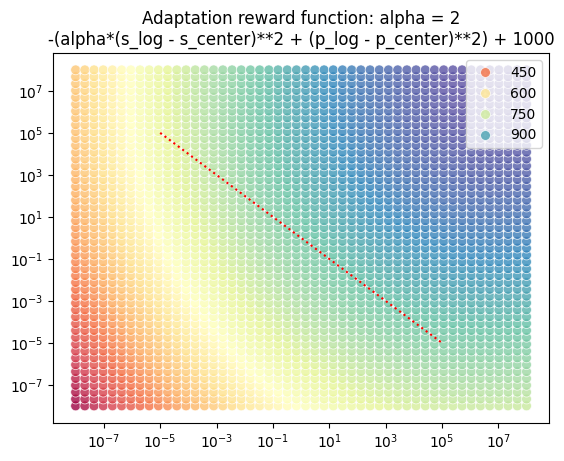

In [13]:
alpha = 2
fake_s = np.logspace(-8, 8, 50)
fake_p = np.logspace(-8, 8, 50)
s, p = np.meshgrid(fake_s, fake_p)
a = jax.vmap(partial(calculate_adaptation,
                 alpha=alpha))(s, p)

sns.scatterplot(x=s.flatten(), y=p.flatten(), hue=a.flatten(),
                palette='Spectral', s=50, alpha=0.8)
plt.plot(np.logspace(-5, 5, 100), np.logspace(5, -5, 100), 'r:')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Adaptation reward function: alpha = {alpha}\n-(alpha*(s_log - s_center)**2 + (p_log - p_center)**2) + 1000')

# Investigating if sensitivity peak is still present

<Axes: xlabel='sensitivity', ylabel='Count'>

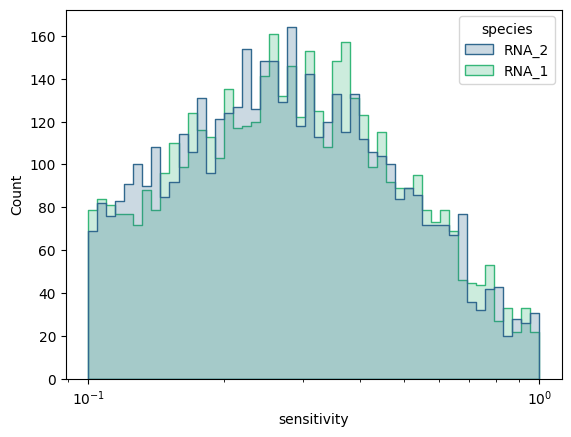

In [14]:
sns.histplot(data[data['species'].isin(species_unbound[1:]) & data['sensitivity'].between(0.1, 1)], x='sensitivity', hue='species', 
             palette='viridis', element='step', bins=50, log_scale=(True, False))

In [15]:
eqconstants

Array([[[1.3914834e-02, 4.9925107e-04, 4.7300272e-03],
        [1.5052804e-02, 1.7006718e-01, 1.9962979e-03],
        [1.2870696e-01, 1.4604756e-05, 3.4677823e-06]],

       [[1.5052804e-02, 1.7006718e-01, 1.9962979e-03],
        [1.2870696e-01, 1.4604756e-05, 3.4677823e-06],
        [1.4246815e+02, 5.4314185e+02, 4.7676556e-05]],

       [[9.4718561e-03, 7.4250315e-06, 1.9656477e+02],
        [1.4246815e+02, 5.4314185e+02, 4.7676556e-05],
        [7.6416695e+01, 2.2496155e-03, 4.6275444e+01]],

       ...,

       [[5.3271729e+02, 7.8306608e-02, 4.2266253e-01],
        [1.9464487e-02, 7.4168563e-02, 1.8620010e+01],
        [3.7103787e+02, 2.4304343e-02, 1.2875208e-02]],

       [[2.3547899e-02, 7.7618374e-03, 4.2921597e-01],
        [5.4581487e-01, 2.5162473e+00, 1.0558312e-05],
        [8.0067448e-02, 4.0653980e-01, 2.5640233e-04]],

       [[3.0687930e-05, 7.6166494e-04, 4.0441476e+02],
        [4.3865815e-03, 2.5399289e+00, 7.7603173e-01],
        [1.0217185e-02, 4.4995849e-03, 6.0